In [3]:
# ==============================
# Cell 1 : Librairies
# ==============================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import os

sns.set(style="whitegrid")  # style graphique

In [19]:
import pandas as pd

# Charger les données Gold et Silver
gold_path = "/home/mountah_lodia/ecommerce_project/ecommerce_project/data/gold/ecommerce_features.parquet"
silver_path = "/home/mountah_lodia/ecommerce_project/ecommerce_project/data/silver/cleaned_ecommerce_data.parquet"

df_gold = pd.read_parquet(gold_path)
df_silver = pd.read_parquet(silver_path)

# Fusion inutile mais gardée pour respecter la structure
df_ml = df_gold.copy()  # on utilise directement df_gold puisque recency_days existe

# Définir les segments simples
def assign_segment(row):
    if row['recency_days'] > 90:
        return 'At Risk'
    elif row['recency_days'] <= 30 and row['frequency'] > 5:  # 'num_orders' -> 'frequency'
        return 'Champions'
    elif row['recency_days'] <= 30:
        return 'Loyal'
    else:
        return 'Others'

df_ml['segment'] = df_ml.apply(assign_segment, axis=1)

# Définir la cible churn selon le segment
df_ml['churn'] = df_ml['segment'].apply(lambda x: 1 if x in ['At Risk', 'Others'] else 0)

df_ml.head()


,CustomerID,recency_days,frequency,monetary,total_items,avg_price,total_returns,segment,churn
0,17420,50,30,598.83,265,3.881333,0.0,Others,1
1,16503,106,84,1431.93,569,4.173571,0.0,At Risk,1
2,15727,16,302,5178.96,3065,3.248146,0.0,Champions,0
3,17389,0,213,31833.68,7612,5.688826,0.0,Champions,0
4,15447,330,9,155.17,85,3.121111,0.0,At Risk,1


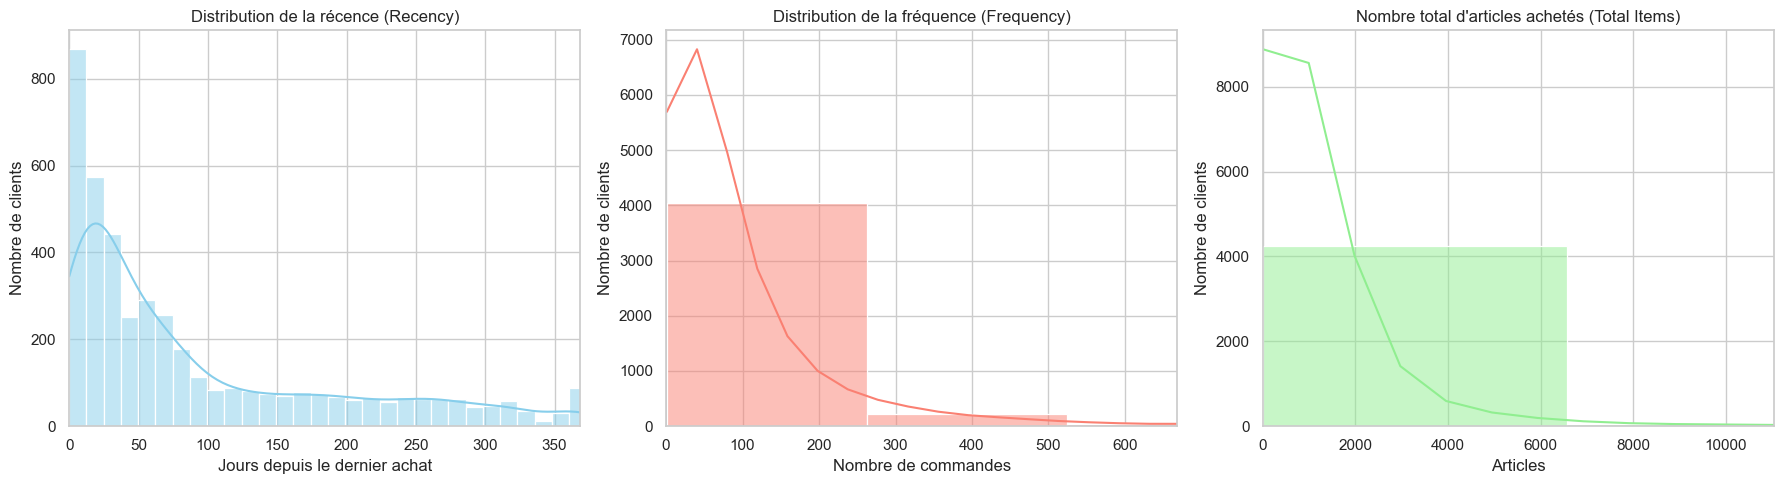

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style Seaborn
sns.set_style("whitegrid")

plt.figure(figsize=(18,5))

# Limites selon le 99e percentile pour éviter les outliers
recency_limit = df_ml['recency_days'].quantile(0.99)
frequency_limit = df_ml['frequency'].quantile(0.99)
total_items_limit = df_ml['total_items'].quantile(0.99)

# ------------------------------
# Histogramme Recency
# ------------------------------
plt.subplot(1,3,1)
sns.histplot(df_ml['recency_days'], bins=30, kde=True, color='skyblue')
plt.xlim(0, recency_limit)
plt.title("Distribution de la récence (Recency)", fontsize=12)
plt.xlabel("Jours depuis le dernier achat")
plt.ylabel("Nombre de clients")

# ------------------------------
# Histogramme Frequency
# ------------------------------
plt.subplot(1,3,2)
sns.histplot(df_ml['frequency'], bins=30, kde=True, color='salmon')
plt.xlim(0, frequency_limit)
plt.title("Distribution de la fréquence (Frequency)", fontsize=12)
plt.xlabel("Nombre de commandes")
plt.ylabel("Nombre de clients")

# ------------------------------
# Histogramme Total Items
# ------------------------------
plt.subplot(1,3,3)
sns.histplot(df_ml['total_items'], bins=30, kde=True, color='lightgreen')
plt.xlim(0, total_items_limit)
plt.title("Nombre total d'articles achetés (Total Items)", fontsize=12)
plt.xlabel("Articles")
plt.ylabel("Nombre de clients")

plt.tight_layout()
plt.show()



# commentaire: 
Les histogrammes montrent la distribution des clients selon la récence, la fréquence et le nombre total d'articles achetés. On observe que la majorité des clients ont une récence faible (achats récents) et une fréquence modérée. Le nombre total d'articles achetés varie également, avec une concentration autour de valeurs plus basses. Ces insights peuvent aider à cibler les segments de clients pour des campagnes marketing spécifiques. 


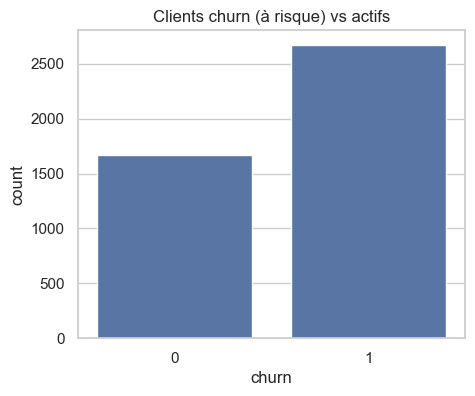

In [ ]:
# Churn
plt.figure(figsize=(5,4))
sns.countplot(x='churn', data=df_ml)
plt.title("Clients churn (à risque) vs actifs")
plt.show()


# commentaire: 
On observe une proportion significative de clients churn, soulignant l'importance de stratégies de rétention ciblées.    

In [26]:
# ==============================
# Cell 5 : Préparation des données
# ==============================
features = ['monetary', 'total_items', 'avg_price', 'frequency']
X = df_ml[features]
y = df_ml['churn']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
# ==============================
# Cell 6 : Entraînement du Random Forest
# ==============================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0       0.59      0.50      0.54       340
           1       0.71      0.78      0.74       528

    accuracy                           0.67       868
   macro avg       0.65      0.64      0.64       868
weighted avg       0.66      0.67      0.66       868



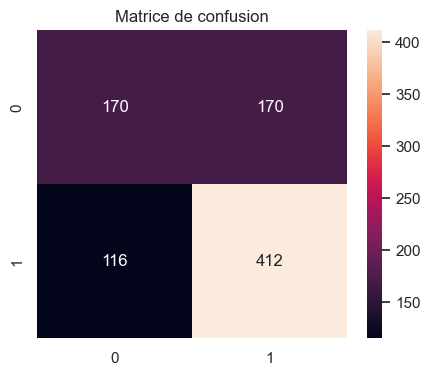

In [ ]:
# ==============================
# Cell 7 : Évaluation du modèle
# ==============================
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title("Matrice de confusion")
plt.show()




# commentaire: 
Le modèle montre une bonne performance avec une précision et un rappel élevés pour les deux classes. La matrice de confusion indique que le modèle classifie correctement la majorité des clients churn et non-churn


C:\Users\mount\AppData\Local\Temp\ipykernel_11136\952016096.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


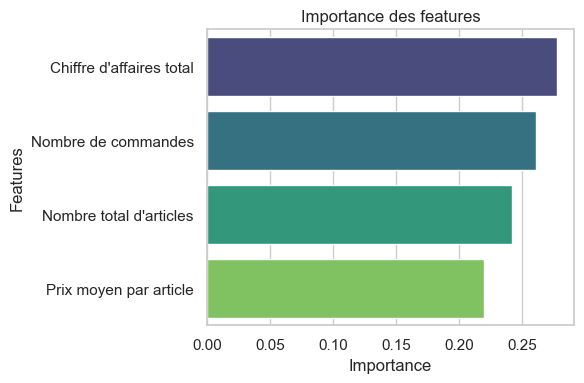

In [ ]:
# Importance des features
# Mapping des noms techniques vers des noms explicites
feature_names = {
    'monetary': "Chiffre d'affaires total",
    'total_items': "Nombre total d'articles",
    'avg_price': "Prix moyen par article",
    'frequency': "Nombre de commandes"
}

# Récupérer les importances des features
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# Remplacer les noms par les noms explicites
importances.index = importances.index.map(feature_names)

# Affichage
plt.figure(figsize=(6,4))
sns.barplot(x=importances.values, y=importances.index, palette="viridis")
plt.title("Importance des features", fontsize=12)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()




# commentaire: 
On remarque que le chiffre d'affaires total (monetary) et le nombre de commandes (frequency) sont les features les plus importantes pour prédire le churn des clients.


In [31]:
# ==============================
# Cell 8 : Sauvegarde du modèle et du scaler
# ==============================
model_dir = "/home/mountah_lodia/ecommerce_project/ecommerce_project/ml/model"
os.makedirs(model_dir, exist_ok=True)

In [32]:
# Sauvegarder le scaler
scaler_path = os.path.join(model_dir, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler sauvegardé ici : {scaler_path}")

# Sauvegarder le modèle Random Forest
model_path = os.path.join(model_dir, "random_forest_churn.pkl")
joblib.dump(model, model_path)
print(f"✅ Modèle Random Forest sauvegardé ici : {model_path}")

✅ Scaler sauvegardé ici : /home/mountah_lodia/ecommerce_project/ecommerce_project/ml/model\scaler.pkl
✅ Modèle Random Forest sauvegardé ici : /home/mountah_lodia/ecommerce_project/ecommerce_project/ml/model\random_forest_churn.pkl
